## Libarary 불러오기

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm 
import glob 

import matplotlib.pyplot as plt
import numpy as np 

## Albumentation (get_transform 정의)

In [3]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

    return transformations

## Model 정의

In [4]:
import timm 

In [5]:
device =  torch.device("cuda")
model = timm.create_model('resnet50', pretrained=True) # resnet50 

In [6]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet50'}

## Custom Dataset class (미션 코드)

강의 코드랑 다른점은 `__getitem()__` 부분 

```python
return {'image': image_transform, 'mask': mask_label, 'gender': gender_label, 'age': age_label}
```
dictionary, label 별로 return 

In [8]:
from enum import Enum # 서로 관련이 있는 여러개의 상수의 집합 정의 
# .name 이랑 .value 통해서 이름이랑 값 호출 가능 

class MaskLabels(int, Enum): 
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

In [9]:
class MaskBaseDataset(Dataset):
    

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, mean, std, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return {'image': image_transform, 'mask': mask_label, 'gender': gender_label, 'age': age_label}

    def __len__(self):
        return len(self.image_paths)

In [10]:
# 미션 코드로 얻은 평균, 표준편차 값 
mean = [0.56019265, 0.52410305, 0.50145299]
std = [0.23308824, 0.24294489, 0.2456003]

In [11]:
# transform 할당 
transform = get_transforms(mean=mean, std=std, img_size=(224, 224))

In [12]:
# train 데이터 경로 설정 
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [13]:
# trainset 정의 
trainset = MaskBaseDataset(img_dir=img_dir, mean=mean, std=std, transform=transform)

In [14]:
# train, valid 분리용
from sklearn.model_selection import train_test_split

In [15]:
# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(trainset) * 0.2)
n_train = len(trainset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

In [16]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
train_steps = len(train_loader.dataset) // BATCH_SIZE
val_steps = len(val_loader.dataset) // BATCH_SIZE

In [17]:
# shape 확인 
data_dict = next(iter(train_loader))
print("image.shape: ", data_dict['image'].shape)
print("label.gender.shape: ", data_dict['gender'].shape)
print("label.mask.shape: ", data_dict['mask'].shape)
print("label.age.shape: ", data_dict['age'].shape)

image.shape:  torch.Size([64, 3, 224, 224])
label.gender.shape:  torch.Size([64])
label.mask.shape:  torch.Size([64])
label.age.shape:  torch.Size([64])


In [18]:
from collections import OrderedDict

## MultiTask 모델 만들기
위에서 다운받은 resnet 기반, forward에서 3가지의 pred label 반환 

In [19]:
class MultiTaskNet(nn.Module):
    def __init__(self, net):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 1))]))
        self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 3))]))
        self.net.fc3 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 3))]))
        
    def forward(self, x):
        gender_head = self.net.fc1(self.net(x))
        age_head = self.net.fc2(self.net(x))
        mask_head = self.net.fc3(self.net(x))
        return age_head, gender_head, mask_head

mask, age는 다중 분류, 성별은 이진분류 Loss 적용 

In [20]:
net = MultiTaskNet(model)
net.to(device=device)

mask_loss = nn.CrossEntropyLoss() # Includes Softmax
gender_loss = nn.BCELoss() # Don't include Softmax
age_loss = nn.CrossEntropyLoss()

lr = 1e-4
momentum = 0.09 # Meaning that we will go 9% with the previous direction
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [21]:
n_epochs = 10

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_mask_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_mask_loss": list(),
          "validation_age_loss": list(),
          }

## Train Code 

In [22]:
sig = nn.Sigmoid()

for epoch in tqdm(range(n_epochs)):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_mask_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_mask_loss = 0
    validation_age_loss = 0

    for i, data in tqdm(enumerate(train_loader)):
        
        inputs = data["image"].to(device=device)

        age_label = data["age"].to(device=device)
        gender_label = data["gender"].to(device=device)
        mask_label = data["mask"].to(device=device)

        optimizer.zero_grad()
        age_output, gender_output, mask_output = net(inputs)
        #print(type(age_label.unsqueeze(1)))
        #print(age_output.shape, age_label.shape)

        loss_1 = age_loss(age_output, age_label)
        loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
        loss_3 = mask_loss(mask_output, mask_label)
        
        loss = loss_1 + loss_2 + loss_3

        loss.backward()
        optimizer.step()
        total_training_loss += loss

        training_age_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_mask_loss += loss_3.item()
        
        

    print('EPOCH ', epoch+1)
    print("Training Losses: Mask: {}, Gender: {}, Age: {}".format(loss_3, loss_2, loss_1))

    with torch.no_grad():
        model.eval()

        for i, data in tqdm(enumerate(val_loader)):
            inputs = data["image"].to(device=device)

            age_label = data["age"].to(device=device)
            gender_label = data["gender"].to(device=device)
            mask_label =  data["mask"].to(device=device)
            age_output, gender_output, mask_output = net(inputs)
            # print(age_output, age_label.unsqueeze(1).float())
            loss_1 = age_loss(age_output, age_label)
            loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
            loss_3 = mask_loss(mask_output, mask_label)

            loss = loss_1 + loss_2 + loss_3
            total_validation_loss += loss
            
            validation_age_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_mask_loss += loss_3.item()
            
            
        print("Validation Losses: Mask: {}, Gender: {}, Age: {}".format(loss_3, loss_2, loss_1))

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_loader.dataset)
    avgTrainMaskLoss = training_mask_loss/len(train_loader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_loader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_loader.dataset)
    avgValMaskLoss = validation_mask_loss/len(val_loader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_loader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_mask_loss"].append(avgTrainMaskLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_mask_loss"].append(avgValMaskLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)

237it [03:05,  1.28it/s]0:00<?, ?it/s]


EPOCH  1
Training Losses: Mask: 1.0774877071380615, Gender: 0.685883641242981, Age: 1.0866641998291016


60it [00:22,  2.63it/s]
 10%|█         | 1/10 [03:28<31:14, 208.27s/it]

Validation Losses: Mask: 1.04362154006958, Gender: 0.6991575360298157, Age: 1.1004831790924072
Average Losses — Training: 2.8615264892578125 | Validation 2.8692691326141357



237it [03:05,  1.28it/s]


EPOCH  2
Training Losses: Mask: 1.015594482421875, Gender: 0.6903163194656372, Age: 1.081099510192871


60it [00:22,  2.65it/s]
 20%|██        | 2/10 [06:56<27:45, 208.18s/it]

Validation Losses: Mask: 1.0059202909469604, Gender: 0.6987462043762207, Age: 1.095313549041748
Average Losses — Training: 2.803129196166992 | Validation 2.817389965057373



237it [03:04,  1.28it/s]


EPOCH  3
Training Losses: Mask: 1.0335135459899902, Gender: 0.6924080848693848, Age: 1.0447746515274048


60it [00:22,  2.67it/s]
 30%|███       | 3/10 [10:23<24:15, 207.98s/it]

Validation Losses: Mask: 0.9633686542510986, Gender: 0.7038777470588684, Age: 1.0896540880203247
Average Losses — Training: 2.7512173652648926 | Validation 2.7652699947357178



237it [03:03,  1.29it/s]


EPOCH  4
Training Losses: Mask: 1.0074790716171265, Gender: 0.6691505908966064, Age: 1.0082297325134277


60it [00:23,  2.61it/s]
 40%|████      | 4/10 [13:50<20:46, 207.67s/it]

Validation Losses: Mask: 0.934658944606781, Gender: 0.7011458277702332, Age: 1.0815403461456299
Average Losses — Training: 2.704392433166504 | Validation 2.727454662322998



237it [03:04,  1.29it/s]


EPOCH  5
Training Losses: Mask: 0.9324437379837036, Gender: 0.696050226688385, Age: 1.0658960342407227


60it [00:22,  2.62it/s]
 50%|█████     | 5/10 [17:18<17:17, 207.59s/it]

Validation Losses: Mask: 0.9111223816871643, Gender: 0.7011353373527527, Age: 1.087842583656311
Average Losses — Training: 2.6628146171569824 | Validation 2.687324047088623



237it [03:03,  1.29it/s]


EPOCH  6
Training Losses: Mask: 0.8519153594970703, Gender: 0.7071723341941833, Age: 1.006359577178955


60it [00:23,  2.58it/s]
 60%|██████    | 6/10 [20:45<13:49, 207.47s/it]

Validation Losses: Mask: 0.8806403875350952, Gender: 0.699766218662262, Age: 1.0815396308898926
Average Losses — Training: 2.6252963542938232 | Validation 2.651608467102051



237it [03:04,  1.28it/s]


EPOCH  7
Training Losses: Mask: 0.8194336891174316, Gender: 0.6986117362976074, Age: 0.9799362421035767


60it [00:23,  2.58it/s]
 70%|███████   | 7/10 [24:13<10:22, 207.65s/it]

Validation Losses: Mask: 0.8585830926895142, Gender: 0.7012985944747925, Age: 1.0795278549194336
Average Losses — Training: 2.5919981002807617 | Validation 2.628143548965454



237it [03:04,  1.29it/s]


EPOCH  8
Training Losses: Mask: 0.9286839962005615, Gender: 0.6940533518791199, Age: 0.9990453720092773


60it [00:22,  2.63it/s]
 80%|████████  | 8/10 [27:40<06:55, 207.51s/it]

Validation Losses: Mask: 0.8532581925392151, Gender: 0.6998184323310852, Age: 1.0849040746688843
Average Losses — Training: 2.5624911785125732 | Validation 2.601574659347534



237it [03:03,  1.29it/s]


EPOCH  9
Training Losses: Mask: 0.914039134979248, Gender: 0.7012348771095276, Age: 0.9892091155052185


60it [00:22,  2.61it/s]
 90%|█████████ | 9/10 [31:07<03:27, 207.35s/it]

Validation Losses: Mask: 0.8263145089149475, Gender: 0.7009445428848267, Age: 1.0778300762176514
Average Losses — Training: 2.53648042678833 | Validation 2.569553852081299



237it [03:03,  1.29it/s]


EPOCH  10
Training Losses: Mask: 0.7993543744087219, Gender: 0.6550008654594421, Age: 0.9335858821868896


60it [00:22,  2.65it/s]
100%|██████████| 10/10 [34:33<00:00, 207.38s/it]

Validation Losses: Mask: 0.7928236722946167, Gender: 0.703321635723114, Age: 1.0778135061264038
Average Losses — Training: 2.512552261352539 | Validation 2.5553157329559326



## Train, Valid Loss plot 

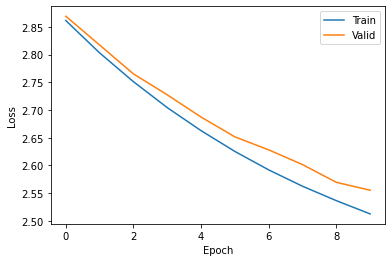

In [23]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

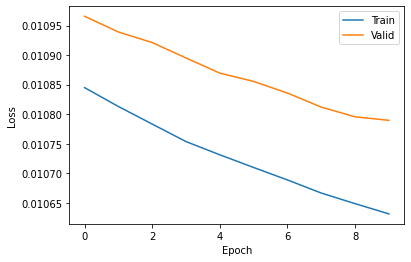

In [24]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

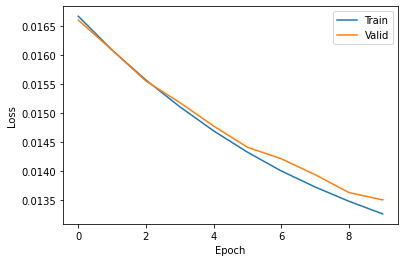

In [26]:
plt.plot(logger["train_mask_loss"])
plt.plot(logger["validation_mask_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

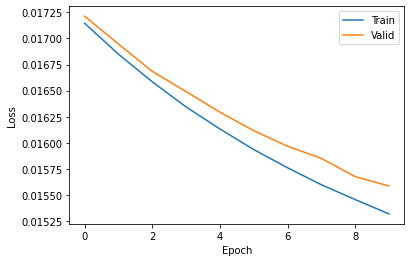

In [27]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [1]:
torch.save(net, "checkpoint/resnet50_10epochs.pth")

NameError: name 'torch' is not defined

In [37]:
net(torch.Tensor(trainset[0]['image']).unsqueeze(0).to(device))

(tensor([[ 0.1680,  0.1683, -0.3452]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.1573]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.4176, -0.2435, -0.2517]], device='cuda:0', grad_fn=<AddmmBackward>))